# Introduction

### Goal: 
The purpose of this research is to build a classifier that can correctly diagnose Pneumonia. Why Pneumonia?

* 100,000 Deaths per year due to the misdiagnosis of pneumonia. Wrongful diagnosis of pneumonia can be very life threatening given that it leads to an increase in severity due to lack of treatment. Especially in cases where the patient might have a more serious infection like COVID-19.

* Pneumonia is the reason for 1 out of 6 childhood death making it the leading cause of fatality in kids under 5 years.

* In the United States, the death rate of pneumonia is 10 out of every 100,000 individuals and this usually the rate in most developed countries. Meanwhile, in Africa, the death rate of pneumonia is 100 out of every 100,000 individuals and this is normal in most developing countries.


### Data: 
For this research, I used the Pneumonia dataset from Kaggle’s website. I used 2,682 x-ray images of patient which were labeled by a specialist as either Normal or Pneumonia. The merged dataset file can be found in the xray folder of this repository. The datasets downloaded can be found: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


### Approach: 
The data was imbalanced so I'll use ImageDataGenerator to create additional dataset to help our modeling training. This will allow the network to see more diversification withing the dataset without any reduction in how representative the dataset for each category is during training. I won’t do the same for the test dataset as I won’t want to tamper with the data that I’ll be validating with. My parameters here are;

* shear_range=0.2
* rotation_range=20
* width_shift_range=0.2
* height_shift_range=0.2
* horizontal_flip=True
* vertical_flip=False
* zoom_range=0.2

After that, I inserted the images using flow. My parameters are; 32 images should be used for training at a given instance (batch size), my image size is 64 X 64 and the class mode is set to categorical.

#### ModelCheckpoint
* monitor = val_loss
* mode = min
* save_best_only = True
* verbose = 1

#### EarlyStopping
* monitor = val_loss
* mode = min
* save_best_only = True
* verbose= 1

#### ReduceLROnPlateau
* monitor = val_loss
* patience = 30
* verbose = 1 
* factor = 0.8
* min_lr = 0.0001
* mode = auto
* min_delta = 0.0001
* cooldown = 5

I go on and apply the same parameters I used for my training dataset to my test dataset and then I call my fit 100 epochs.

### Methods: 
The network used is VGG19 because it’s known for having pretty high accuracies for image classification problems so I have no doubt it would work perfectly for my problem. After importing my VGG19 model and set the appropriate weights for the type of images in the dataset and set the Include Top parameter to false. This will ensure that the last layer is drop and I did this because I don’t want to classify thousand different categories when my specific problem only has two categories. So, for this I skip the last layer. The first layer is also dropped since I can simply provide my own image size as I did.

In [1]:
# importing neccessary libraries
from glob import glob
import numpy as np
import pandas as pd
import random
from skimage.io import imread
import os, shutil
import tensorflow as tf
import keras
from tensorflow.keras.layers import Input, MaxPooling2D
from collections import Counter
from scikitplot.metrics import plot_roc
from sklearn import metrics
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
import scikitplot
import sklearn
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier,AdaBoostClassifier,RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import VarianceThreshold
from sklearn import datasets 
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from sklearn import tree
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import validation_curve
import imblearn
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import precision_score, precision_recall_curve, average_precision_score, recall_score, accuracy_score, f1_score, make_scorer, classification_report, auc, roc_curve, roc_auc_score, confusion_matrix
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from keras.applications import MobileNet, DenseNet201, DenseNet121, VGG19, InceptionV3, MobileNetV2, Xception, ResNet152V2, NASNetLarge
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\jrizz_000\anaconda3\anaconda3\envs\learn-env\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Data Processessing

In [2]:
# counting the amount of x rays images
len_normal_train = len([iq for iq in os.scandir('xrays/normalvspneumonia/train/normal')])
len_normal_test = len([iq for iq in os.scandir('xrays/normalvspneumonia/test/normal')])
len_normal_val = len([iq for iq in os.scandir('xrays/normalvspneumonia/val/normal')])

len_pneumonia_train = len([iq for iq in os.scandir('xrays/normalvspneumonia/train/pneumonia')])
len_pneumonia_val = len([iq for iq in os.scandir('xrays/normalvspneumonia/val/pneumonia')])
len_pneumonia_test = len([iq for iq in os.scandir('xrays/normalvspneumonia/test/pneumonia')])

len_train_total = len_normal_train + len_pneumonia_train
len_val_total = len_pneumonia_val + len_normal_val
len_test_total = len_normal_test + len_pneumonia_test

print("Total")
print("---------------------")
print ("normal: ", len_normal_train)
print ("normal no val: ", len_normal_val)
print ("normal no test: ", len_normal_test)
print("---------------------")
print ("pneumonia no train: ", len_pneumonia_train)
print ("pneumonia no val: ", len_pneumonia_val)
print ("pneumonia no test: ", len_pneumonia_test)
print()
print("Total")
print("---------------------")
print("total train: ", len_train_total)
print("total val: ", len_val_total)
print("total test: ", len_test_total)


Total
---------------------
normal:  863
normal no val:  206
normal no test:  272
---------------------
pneumonia no train:  845
pneumonia no val:  226
pneumonia no test:  270

Total
---------------------
total train:  1708
total val:  432
total test:  542


In [3]:
# extracting the images
DIR_NAME = 'xrays/normalvspneumonia/'

imagePaths=[]
for dirname, _, filenames in os.walk(DIR_NAME):
    for filename in filenames:
        imagePaths.append(os.path.join(dirname, filename))

In [4]:
# verifying if the images have been extracted
imagePaths

['xrays/normalvspneumonia/test\\normal\\NORMAL (432).png',
 'xrays/normalvspneumonia/test\\normal\\NORMAL (433).png',
 'xrays/normalvspneumonia/test\\normal\\NORMAL (433)_1.png',
 'xrays/normalvspneumonia/test\\normal\\NORMAL (434).png',
 'xrays/normalvspneumonia/test\\normal\\NORMAL (434)_1.png',
 'xrays/normalvspneumonia/test\\normal\\NORMAL (435).png',
 'xrays/normalvspneumonia/test\\normal\\NORMAL (435)_1.png',
 'xrays/normalvspneumonia/test\\normal\\NORMAL (436).png',
 'xrays/normalvspneumonia/test\\normal\\NORMAL (436)_1.png',
 'xrays/normalvspneumonia/test\\normal\\NORMAL (437).png',
 'xrays/normalvspneumonia/test\\normal\\NORMAL (437)_1.png',
 'xrays/normalvspneumonia/test\\normal\\NORMAL (438).png',
 'xrays/normalvspneumonia/test\\normal\\NORMAL (438)_1.png',
 'xrays/normalvspneumonia/test\\normal\\NORMAL (439).png',
 'xrays/normalvspneumonia/test\\normal\\NORMAL (439)_1.png',
 'xrays/normalvspneumonia/test\\normal\\NORMAL (440).png',
 'xrays/normalvspneumonia/test\\normal\\NO

In [95]:
# assigining the labels to the images
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (64, 64))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

In [96]:
# verifying the shape
data.shape

(2682, 64, 64, 3)

In [97]:
# verifying the labels
labels

array(['normal', 'normal', 'normal', ..., 'pneumonia', 'pneumonia',
       'pneumonia'], dtype='<U9')

In [98]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels =to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(x_train, x_test, y_train, y_test) = train_test_split(data, labels,
    test_size=0.20, stratify=labels,shuffle= True, random_state=42)


In [10]:
x_train

array([[[[0.03529412, 0.03529412, 0.03529412],
         [0.15294118, 0.15294118, 0.15294118],
         [0.26666667, 0.26666667, 0.26666667],
         ...,
         [0.23137255, 0.23137255, 0.23137255],
         [0.17647059, 0.17647059, 0.17647059],
         [0.07843137, 0.07843137, 0.07843137]],

        [[0.01960784, 0.01960784, 0.01960784],
         [0.15294118, 0.15294118, 0.15294118],
         [0.23529412, 0.23529412, 0.23529412],
         ...,
         [0.22745098, 0.22745098, 0.22745098],
         [0.16470588, 0.16470588, 0.16470588],
         [0.0627451 , 0.0627451 , 0.0627451 ]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.12941176, 0.12941176, 0.12941176],
         [0.23137255, 0.23137255, 0.23137255],
         ...,
         [0.22745098, 0.22745098, 0.22745098],
         [0.1372549 , 0.1372549 , 0.1372549 ],
         [0.05098039, 0.05098039, 0.05098039]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

# Data Augmentation

In [99]:
# Data Augmentation
def process_data(x_train,y_train, x_test,y_test, batch_size):
    '''Takes in x_train,y_train, x_test,y_test, batch_size and returns batches of image data with real-time data augmentation'''
    
    train_datagen = ImageDataGenerator(shear_range=0.2,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                       zoom_range=0.2)


    validation_datagen = ImageDataGenerator(validation_split=0.4)

    train_generator = train_datagen.flow(x_train,y_train,
                                                        batch_size=batch_size)

    test_generator = validation_datagen.flow(x_test,y_test, subset = 'training',
                                                  batch_size=batch_size)

    validation_generator = validation_datagen.flow(x_test,y_test, subset ='validation',
                                                  batch_size=batch_size)


    return train_generator, validation_generator, test_generator 

# Transfer Learning

In [10]:
# build sequencial model
def build_model(bottom_model, num_classes):
    '''Takes in the model and number of classes and returns a model with additional layers'''
    top_model = bottom_model.output
    top_model = MaxPooling2D(pool_size=(2,2), strides=2)(top_model)
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(2, activation='sigmoid')(top_model)
    model = Model(inputs=bottom_model.input, outputs=top_model)
    
    return model

In [13]:
# adding top layer
def addTopModel(bottom_model, num_classes):
    '''Takes in the model and number of classes and returns a model with additional layers'''
    top_model = bottom_model.output
    top_model = MaxPooling2D(pool_size=(2,2), strides=2)(top_model)
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(512, activation="relu")(top_model)
    top_model = Dropout(0.5)(top_model)
    top_model = Dense(2, activation='sigmoid')(top_model)
    model = Model(inputs=bottom_model.input, outputs=top_model)
    
    return model


# Confusion Matrix

In [148]:
# plotting confusion matrix for testing
def plot_confusion_matrix(model, test_generator):
    '''Takes in the model, x_test and y_test and returns a confusion matrix plot'''
    test_generator.reset()
    
    fig, ax = plt.subplots(figsize=(8,6))

    classes = ['PNEUMONIA','NORMAL']
        
    x_test, y_test = test_generator.next()
    y_test = np.argmax(y_test, axis=1) 
    
    y_pred = model.predict(x_test, batch_size = batch_size)
    y_pred = np.argmax(y_pred, axis=1)
    
    print('Confusion Matrix')
    
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    #cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 
    sns.heatmap(cm,cmap='Purples',fmt='g', annot=True)
    tick_marks = [0.5,1.5]
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.title('Confusion Matrix - Normalized')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    bottom, top = ax.get_ylim()
    
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    plt.show()
    
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=None)
    recall = recall_score(y_test, y_pred, average=None)
    f1 = f1_score(y_test, y_pred, average=None)
    
    print("Precision Score: {}".format(precision))
    print("Recall Score: {}".format(recall))
    print("F1 Score: {}".format(f1))
    print("Accuracy Score: {}".format(acc))

    return plt.show()

# ROC AUC

In [132]:
#ROC curve
def multiclass_roc_auc_score(test_gen, model, average="micro"):
    '''Takes in the model, x_test and y_test and returns a roc curve'''
    x_test, y_test = test_gen.next()
#     y_test = np.argmax(y_test, axis=1)
    
    y_pred = model.predict(x_test, batch_size=batch_size)
    
    # Convert to Binary classes
    y_pred_bin = np.argmax(y_pred, axis=1)
    y_test_bin = np.argmax(y_test, axis=1)

    
    fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
    
    auc_keras = auc(fpr, tpr)
    
    print('AUC: {}'.format(auc_keras))    
    print('Log Loss: {}'.format(metrics.log_loss(y_test.argmax(axis=1), y_pred)))

        
    plt.plot(fpr, tpr,  color='darkorange', label='ROC curve (area = %0.2f)' % auc_keras)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for our model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='best', fancybox=True)
    plt.grid(True)


    return plt.show()

# Model Loss

In [125]:
#model loss
def plot_learning_curves(r):
    '''Takes in the models history and returns a plot of the history of the log loss and the accuracy'''
    
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(r.history['loss'])
    plt.plot(r.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid(True)
    
    plt.subplot(1,2,2)
    plt.plot(r.history['accuracy'])
    plt.plot(r.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    
    return plt.show()

# Assigning Parameters

In [113]:
#parameters
data_dir = '/'
version = '-v5-'
num_classes = 2
ig_size= 64
epochs = 100
batch_size = 32

models_loss = 'binary_crossentropy'
models_opt = 'adam' #Adam(lr=0.001, decay=0.001/600) #SGD(learning_rate=0.001, momentum=0.9) #ADAM(lr=0.001)

# Modeling - Base CNN Model

First, I used the sequential keras model which is th easiest way to build a model in keras. It allows one to build a model, layer by layer. My first layer will be a Conv2D layer that will deal with my input x-ray images of shape 64, 64, 3 using 64 nodes. The 3 in the shape sigifying that the images are in RGB. The kernel size is set to 3, which means the filter that would be used to scan through every pixel will be a matrix of 3x3. 

Next, a MaxPooling2D layer was utilized in order to reduce overfitting and dimentionality i.e in order to reduce the number of parameters to learn from and the amount of comuputation performed in the network. I set it to divide the dimentions by a matrix of 2x2 while moving 2 strides after choosing the maximum value of each patch. After this, I flattened the output from the MaxPooling layer in order to make it linear and pass it to the Dense layer implemented, which uses a node of 2 which represents the number of output classes to be predicted.

In [120]:
# calling thesequential model
m = Sequential(Conv2D(ig_size, kernel_size=3, activation='relu', 
                      input_shape=(64,64,3)))

model = build_model(m, num_classes) 


 #data augmentation
train_generator, validation_generator, test_generator = process_data(x_train,y_train,
                                                 x_test,y_test, batch_size)
model.summary()

checkpoint = ModelCheckpoint(data_dir+'sequentialpnd' + '.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)


callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])

x_val, y_val = test_generator.next()
x_tran, y_tran = train_generator.next()

history = model.fit(train_generator,
                             epochs=epochs,
                               callbacks=callbacks,
                               validation_data=validation_generator)

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18_input (InputLayer) [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 123010    
Total params: 124,802
Trainable params: 124,802
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.5203
Epoch 00001: val_loss i

Epoch 25/100
68/68 [==============================] - ETA: 0s - loss: 0.3122 - accuracy: 0.8667
Epoch 00025: val_loss did not improve from 0.21894
68/68 [==============================] - 10s 144ms/step - loss: 0.3122 - accuracy: 0.8667 - val_loss: 0.3893 - val_accuracy: 0.8318 - lr: 0.0010
Epoch 26/100
68/68 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.8704
Epoch 00026: val_loss improved from 0.21894 to 0.17586, saving model to /sequentialpnd.h5
68/68 [==============================] - 10s 142ms/step - loss: 0.3236 - accuracy: 0.8704 - val_loss: 0.1759 - val_accuracy: 0.9626 - lr: 0.0010
Epoch 27/100
68/68 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.8876
Epoch 00027: val_loss did not improve from 0.17586
68/68 [==============================] - 10s 151ms/step - loss: 0.2821 - accuracy: 0.8876 - val_loss: 0.1830 - val_accuracy: 0.9533 - lr: 0.0010
Epoch 28/100
68/68 [==============================] - ETA: 0s - loss: 0.2926 - accura

# Testing

Confusion Matrix


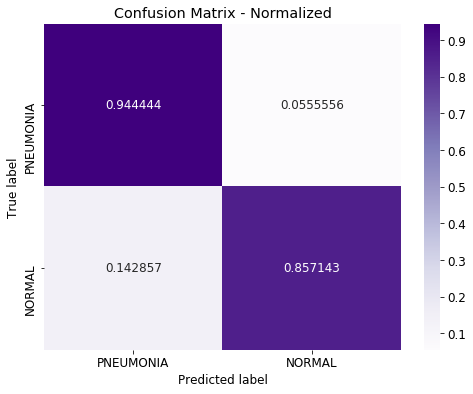

Precision Score: [0.89473684 0.92307692]
Recall Score: [0.94444444 0.85714286]
F1 Score: [0.91891892 0.88888889]
Accuracy Score: 0.90625


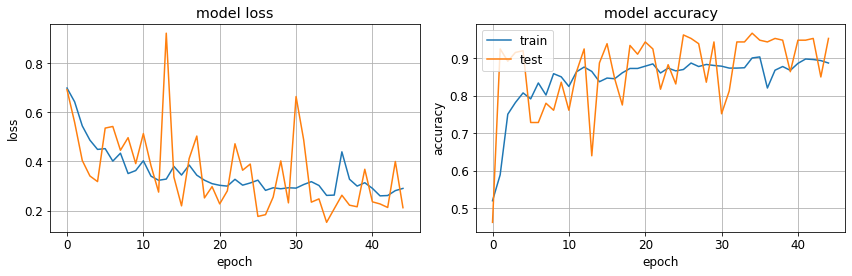

AUC: 0.8967611336032391
Log Loss: 0.2574813416322286


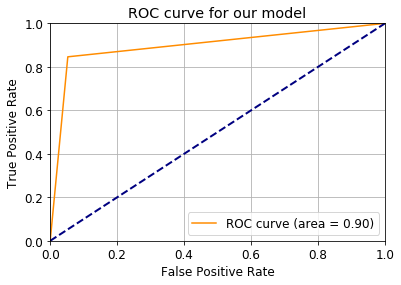

In [152]:
## Confusion matrix
plot_confusion_matrix(model,test_generator)
## Learning curve
plot_learning_curves(history)
## ROC AUC
multiclass_roc_auc_score(test_generator, model)

In [89]:
# saving model
model.save("sequentialpnd.h5")

In [90]:
from keras.models import load_model
model = load_model('./sequentialpnd.h5')

# Modeling - Using VGG19

VGG-19 is a transfer learning alorithm which means its an algorithm with 16 convolutional layers that focuses on storing knowledge that can be applied to different but relaed problems.

In [154]:
# assiging the VGG19 model
m = VGG19(weights="imagenet", include_top=False, 
          input_tensor=Input(shape=(64, 64, 3)))

model = addTopModel(m, num_classes) 

for layer in m.layers:
    layer.trainable = False
 

 #data augmentation
train_generator, validation_generator, test_generator = process_data(x_train,y_train,
                                                 x_test,y_test, batch_size)


model.summary()

checkpoint = ModelCheckpoint(data_dir+'modelpnd' + '.h5',
                             monitor='val_loss',
                             mode="min",
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=30,
                          verbose=1,
                          restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=30,
                                            verbose=1,
                                            factor=0.8,
                                            min_lr=0.0001,
                                            mode="auto",
                                            min_delta=0.0001,
                                            cooldown=5)


callbacks = [checkpoint, earlystop, learning_rate_reduction]

model.compile(loss=models_loss,
              optimizer=models_opt,
              metrics=['accuracy'])


history = model.fit(train_generator,
                             epochs=epochs,
                               callbacks=callbacks,
                               validation_data=validation_generator)

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0  

68/68 [==============================] - ETA: 0s - loss: 0.3046 - accuracy: 0.8793
Epoch 00015: val_loss improved from 0.20239 to 0.17420, saving model to /modelpnd.h5
68/68 [==============================] - 87s 1s/step - loss: 0.3046 - accuracy: 0.8793 - val_loss: 0.1742 - val_accuracy: 0.9393 - lr: 0.0010
Epoch 16/100
68/68 [==============================] - ETA: 0s - loss: 0.3018 - accuracy: 0.8802
Epoch 00016: val_loss did not improve from 0.17420
68/68 [==============================] - 78s 1s/step - loss: 0.3018 - accuracy: 0.8802 - val_loss: 0.3378 - val_accuracy: 0.8411 - lr: 0.0010
Epoch 17/100
68/68 [==============================] - ETA: 0s - loss: 0.3078 - accuracy: 0.8783
Epoch 00017: val_loss did not improve from 0.17420
68/68 [==============================] - 84s 1s/step - loss: 0.3078 - accuracy: 0.8783 - val_loss: 0.2781 - val_accuracy: 0.8598 - lr: 0.0010
Epoch 18/100
68/68 [==============================] - ETA: 0s - loss: 0.2796 - accuracy: 0.8793
Epoch 00018: val

68/68 [==============================] - ETA: 0s - loss: 0.2671 - accuracy: 0.8979
Epoch 00043: val_loss did not improve from 0.16530
68/68 [==============================] - 75s 1s/step - loss: 0.2671 - accuracy: 0.8979 - val_loss: 0.2260 - val_accuracy: 0.8972 - lr: 0.0010
Epoch 44/100
68/68 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.9007
Epoch 00044: val_loss did not improve from 0.16530
68/68 [==============================] - 73s 1s/step - loss: 0.2556 - accuracy: 0.9007 - val_loss: 0.2752 - val_accuracy: 0.8785 - lr: 0.0010
Epoch 45/100
68/68 [==============================] - ETA: 0s - loss: 0.2571 - accuracy: 0.8984
Epoch 00045: val_loss did not improve from 0.16530
68/68 [==============================] - 74s 1s/step - loss: 0.2571 - accuracy: 0.8984 - val_loss: 0.2939 - val_accuracy: 0.8505 - lr: 0.0010
Epoch 46/100
68/68 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.8830
Epoch 00046: val_loss did not improve from 0.16530

# Testing

Confusion Matrix


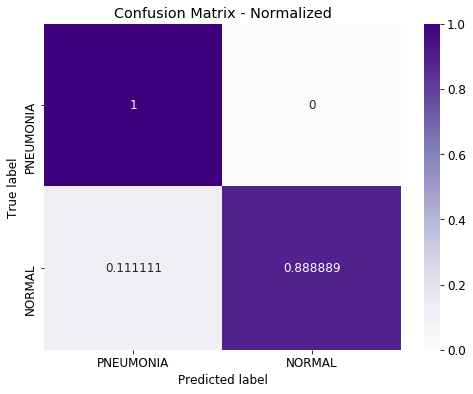

Precision Score: [0.875 1.   ]
Recall Score: [1.         0.88888889]
F1 Score: [0.93333333 0.94117647]
Accuracy Score: 0.9375


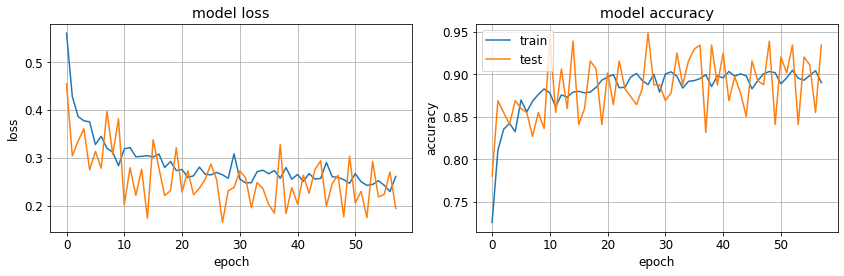

AUC: 0.9007936507936508
Log Loss: 0.16968217714975253


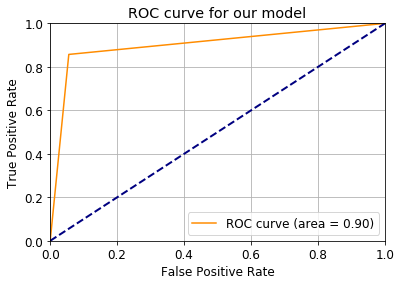

In [163]:
## Confusion matrix
plot_confusion_matrix(model,test_generator)
## Learning curve
plot_learning_curves(history)
## ROC AUC
multiclass_roc_auc_score(test_generator, model)

### Conclusion
The accuracy is 94 % and this is the amount of time the predicted result is actually correct.

The recall percentage is 95% and this is the probability of the model diagnosing a correct positive diagnosis out of all the times it diagnosed positive. This would be the best metric in this case as we would rather give a wrong positive diagnosis than give a wrong negative diagnosis.

### Recommendation
* Use the vgg-19 model since it shows its 5% better at correctly diagnosing a pneumonia than the seqiential model.
* Add a dropout layer before the final dense layer in order to reduce overfitting when using the VGG19 model.

In [131]:
# saving model
model.save("modelpnd.h5")

In [8]:
from keras.models import load_model
model = load_model('./modelpnd.h5')

In [51]:
def get_model(m,x_train,y_train, x_test,y_test):

    model = addTopModel(m, num_classes) 

    for layer in m.layers:
        layer.trainable = False


        #data augmentation
    train_generator, validation_generator = process_data(x_train,y_train,
                                                     x_test,y_test, batch_size)


    model.summary()

    checkpoint = ModelCheckpoint(data_dir+'modelpnd' + '.h5',
                                 monitor='val_loss',
                                 mode="min",
                                 save_best_only=True,
                                 verbose=1)

    earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=30,
                              verbose=1,
                              restore_best_weights=True)

    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                                patience=30,
                                                verbose=1,
                                                factor=0.8,
                                                min_lr=0.0001,
                                                mode="auto",
                                                min_delta=0.0001,
                                                cooldown=5)


    callbacks = [checkpoint, earlystop, learning_rate_reduction]

    model.compile(loss=models_loss,
                  optimizer=models_opt,
                  metrics=['accuracy'])


    history = model.fit(train_generator,
                                 epochs=epochs,
                                   callbacks=callbacks,
                                   validation_data=validation_generator,
                                  validation_steps=len(x_test) / batch_size,
                                  steps_per_epoch=len(x_train) / batch_size)
    return model, history